# 1. Environment configuration

## 1.1 model mixed8_v2

In [ ]:
import sys
sys.path.append('../')

import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os, cv2, glob, shutil, re, time, keras

from IPython.display import clear_output

from keras.optimizers import *
from keras.preprocessing.image import * 
from keras.applications import inception_v3
from keras.applications.xception import preprocess_input 

from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras import backend as K
from PIL import ImageFile

from IPython.display import SVG
from keras.utils import plot_model
from keras.utils import multi_gpu_model
from keras.utils.vis_utils import model_to_dot
from dataload.my_image_attr_cutout_11 import MyImageDataGenerator

from model.new_coremodel import model_mixed8_v7_sn_3_test as my_model

%matplotlib inline
np.random.seed(2018)

ImageFile.LOAD_TRUNCATED_IMAGES = True

gpus = 2
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"

config = tf.ConfigProto()
config.gpu_options.allow_growth=True  
sess = tf.Session(config=config) 

base_project = os.path.abspath('../')
model_image_size =  (444, 592)

In [10]:
basemodel_name = 'inception_v3'
model_new_name = 'v3_mixed8_sn_dilation_v7'
model_h5 = 'v3_mixed8_sn_dilation_v7_201812052028_0.0812_0.9844.h5'
model_path = os.path.join(base_project,  'checkpoints', model_new_name)

model = my_model(basemodel_name=basemodel_name, model_image_size=model_image_size, column_num=1)

model.load_weights(os.path.join(model_path, model_h5))

print('Model has been loaded.') 

Model has been loaded.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 444, 592, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 221, 295, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 221, 295, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 221, 295, 32) 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_96 

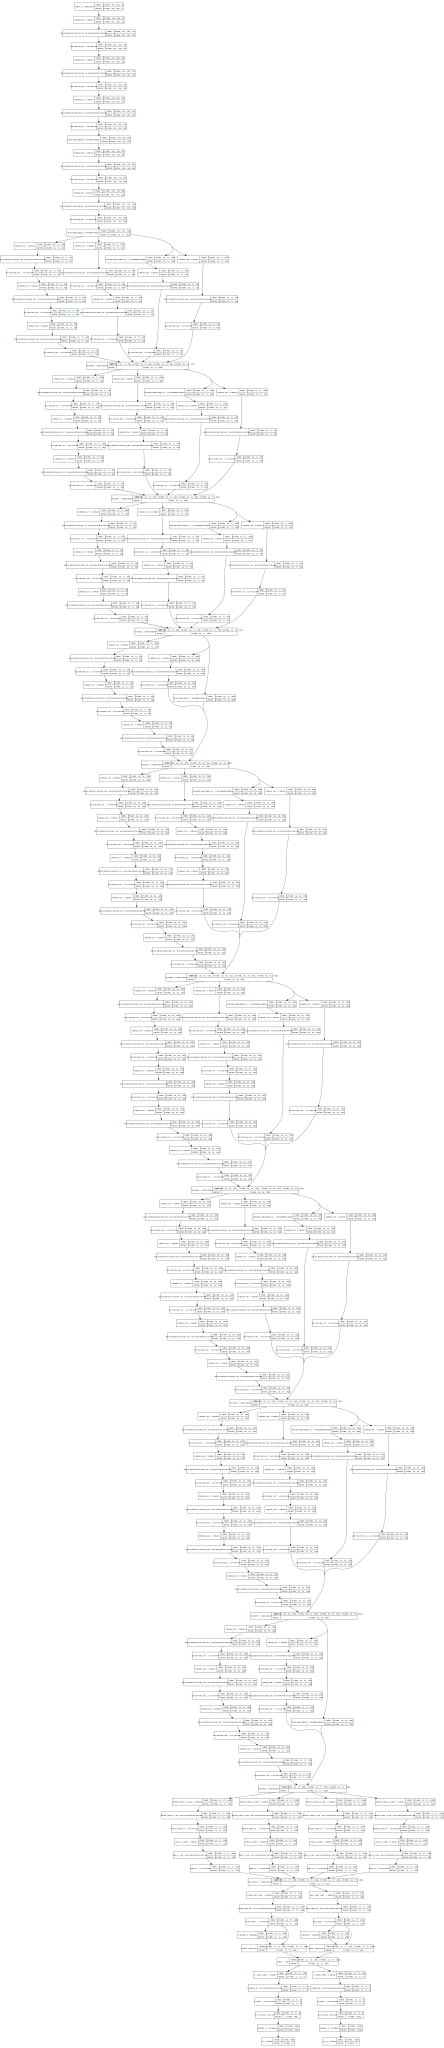

In [7]:
model.summary()
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [15]:
mulmodel = multi_gpu_model(model, gpus=gpus)

task = 'task84_29'

original_basedir = os.path.join(base_project, 'dataspace/v3_symlinks_'+ task) 

start_time = time.time()
eval_gen  = MyImageDataGenerator(preprocessing_function = preprocess_input)

mbatch_size = 128
model_image_size = model_image_size

train_batch_size = mbatch_size
train_generator = eval_gen.myflow_from_directory(
    my_cutout = False,
    directory=os.path.join(original_basedir, 'train'),  
    target_size = model_image_size, shuffle = False, class_mode='binary',  batch_size = train_batch_size)
if train_generator.samples % train_batch_size < gpus:
    steps_train = train_generator.samples // train_batch_size 
else:
    steps_train = train_generator.samples // train_batch_size + 1

print("steps_train = {}".format(steps_train))

test_batch_size = mbatch_size
test_generator = eval_gen.myflow_from_directory(
    directory = os.path.join(original_basedir, 'test'), 
    target_size = model_image_size, shuffle = False,  class_mode = 'binary',  batch_size = test_batch_size)
if test_generator.samples % test_batch_size < gpus:
    steps_test = test_generator.samples // test_batch_size
else:
    steps_test = test_generator.samples // test_batch_size + 1

print("steps_test = {}".format(steps_test))

valid_batch_size = mbatch_size
valid_generator = eval_gen.myflow_from_directory(
    directory = os.path.join(original_basedir, 'valid'),  
    target_size = model_image_size, shuffle=False, class_mode='binary', batch_size=valid_batch_size)
if valid_generator.samples % valid_batch_size < gpus:
    steps_valid = valid_generator.samples // valid_batch_size
else:
    steps_valid = valid_generator.samples // valid_batch_size + 1

  
print("steps_valid = {}".format(steps_valid))

print(train_generator.class_indices)
    
print('total time:{:.1f} minutes.'.format((time.time() - start_time)/60))
print(time.strftime('%Y.%m.%d %H:%M:%S',time.localtime(time.time())))

print('total train images: {}'.format(steps_train * train_batch_size))
print('total test images:  {}'.format( steps_test * test_batch_size))
print('total valid images: {}'.format(steps_valid * valid_batch_size))

Found 0 samples belonging to 2 classes.
steps_train = 0
Found 7655 samples belonging to 2 classes.
steps_test = 60
Found 0 samples belonging to 2 classes.
steps_valid = 0
{'0_normal': 0, '1_abnormal': 1}
total time:0.0 minutes.
2019.01.08 13:54:55
total train images: 0
total test images:  7680
total valid images: 0


# 4. Predict

In [16]:
steps_eval = steps_test
eval_generator = test_generator
dataset = 'test'

# steps_eval = steps_valid
# eval_generator = valid_generator
# dataset = 'valid'

# steps_eval = steps_train
# eval_generator = train_generator
# dataset = 'train'

eval_generator.reset()
pred_result = []
epoch_begin_time = time.time()
nb = 0
for i in range(steps_eval):
    start_time = time.time()
    x, y = eval_generator.next()

    y1, y2 = mulmodel.predict_on_batch(x)
    y1_prob = y1
    y2_prob = y2
    pred_result.append(np.concatenate([y1_prob, y2_prob], axis=-1))

    batch_time = time.time() - start_time
    remaining_time = (steps_eval - i) * batch_time

    if i % 10 == 0:
        print('[{:2d}/{}] ........ {:.2f} seconds/batch, remaining {:.2f} seconds, {}'.format(
              i, steps_eval, batch_time, remaining_time, time.strftime('%H:%M:%S',time.localtime(time.time()))))
    if (i + 1) % 100 == 0:
        clear_output()

print('Done! Total eval time:{:.2f} minutes.'.format((time.time() - epoch_begin_time)/60))
print(time.strftime('%Y.%m.%d %H:%M:%S',time.localtime(time.time())))


[ 0/60] ........ 30.35 seconds/batch, remaining 1820.94 seconds, 13:55:58
[10/60] ........ 4.70 seconds/batch, remaining 235.20 seconds, 13:56:41
[20/60] ........ 3.98 seconds/batch, remaining 159.32 seconds, 13:57:23
[30/60] ........ 4.52 seconds/batch, remaining 135.59 seconds, 13:58:06
[40/60] ........ 3.95 seconds/batch, remaining 79.00 seconds, 13:58:49
[50/60] ........ 4.41 seconds/batch, remaining 44.14 seconds, 13:59:31
Done! Total eval time:4.70 minutes.
2019.01.08 14:00:10


# Analysis

In [17]:

iters = 0
falses = 0
counter1 = 0
counter2 = 0
counter3 = 0
counter4 = 0

normal = 0
abnormal = 1

normal_to_normal = 0
normal_to_abnormal = 0
abnormal_to_normal = 0
abnormal_to_abnormal = 0

pred_class = []
true_class = []
wrong_box = []

data_basedir = original_basedir

T = model_h5[:-3] + '_' + task + '_'+ dataset

project_path = os.path.join(base_project, 'EvalSpace')

abnorm_2_norm   = os.path.join(project_path, model_new_name, T, 'WrongDetection', 'abnorm_2_norm')
norm_2_abnorm   = os.path.join(project_path, model_new_name, T, 'WrongDetection', 'norm_2_abnorm')

norm_2_norm     = os.path.join(project_path,  model_new_name, T, 'RightDetection', 'norm_2_norm')
abnorm_2_abnorm = os.path.join(project_path, model_new_name, T, 'RightDetection', 'abnorm_2_abnorm')

if os.path.exists(abnorm_2_norm):
    shutil.rmtree(abnorm_2_norm)
    shutil.rmtree(norm_2_abnorm)
    shutil.rmtree(abnorm_2_abnorm)
    shutil.rmtree(norm_2_norm)
    
    os.makedirs(abnorm_2_norm)
    os.makedirs(norm_2_abnorm)
    os.makedirs(norm_2_norm)
    os.makedirs(abnorm_2_abnorm)
else:
    os.makedirs(abnorm_2_norm)
    os.makedirs(norm_2_abnorm)
    os.makedirs(norm_2_norm)
    os.makedirs(abnorm_2_abnorm)
    
for out in pred_result:
    
    y1_prob, y2_prob = out[:, 0], out[:, 1:]
    y1_label = y1_prob.round()
    y2_label = y2_prob.max(axis=-1).round()
    tracks = y2_prob.round()
    
    for i in range(len(y1_label)):
        true_label = eval_generator.classes[iters]      # the true binary labels
        img_name = eval_generator.filenames[iters]
        true_tracks = re.split('[_.]', img_name)[-2]    # the true tracks labels
        pred_y1 = y1_label[i]
        iters += 1
        track_str = ''
        for track in tracks[i, :]:
            if int(track) == 1:
                track_str += '1'
            else:
                track_str += '0'      
        
        if '1' in track_str:
            pred_y2 = abnormal
        else:
            pred_y2 = normal

        if pred_y1 == true_label:
            counter1 += 1   
            
        if track_str == true_tracks:
            counter2 += 1
            
        if pred_y2 == true_label:
            counter3 += 1

        if pred_y1 == abnormal:
            fin_output = abnormal
        else:
            fin_output = normal

        pred_class.append(y1_prob[i])
        true_class.append(true_label)

        test_links_path = os.path.join(data_basedir, dataset, img_name)
        fname = re.split('[/.]', img_name)[1] + '_' + track_str + '.jpg'

        if fin_output == true_label:
            if fin_output == abnormal:
                abnormal_to_abnormal += 1
                fname_path = os.path.join(abnorm_2_abnorm, fname)
                os.symlink(os.readlink(test_links_path), fname_path)
            else:
                normal_to_normal += 1
                fname_path = os.path.join(norm_2_norm, fname)
                os.symlink(os.readlink(test_links_path), fname_path)
        else:  
            wrong_box.append(y1_prob[i])
            if fin_output == abnormal:
                normal_to_abnormal += 1
                fname_path = os.path.join(norm_2_abnorm, fname)
                os.symlink(os.readlink(test_links_path), fname_path)
            else:
                abnormal_to_normal += 1
                fname_path = os.path.join(abnorm_2_norm, fname)
                os.symlink(os.readlink(test_links_path), fname_path)
            falses += 1
            display_info = '{} \t {}  \t{} true:{},\t y1:{}, \t y2:{}, \t y3:{}, \t[{:.2f} {:.2f} {:.2f} {:.2f} {:.2f} {:.2f} {:.2f}]'

TP = abnormal_to_abnormal + 1e-100   # true:abnormal to pred:abnormal
FP = normal_to_abnormal   + 1e-100   # true:normal   to pred:abnormal
FN = abnormal_to_normal   + 1e-100   # true:abnormal to pred:normal
TN = normal_to_normal     + 1e-100   # true:normal   to pred:normal

Acc = (TP + TN) / (TP + FP + TN + FN)

R_0 = TN / (TN + FP)
R_1 = TP / (TP + FN)

print('Acc:{:.4f}, 0_recall:{:.4f}, 1_recall:{:.4f}'.format(Acc, R_0, R_1))
print(time.strftime('%Y.%m.%d %H:%M:%S',time.localtime(time.time())))


Acc:0.9945, 0_recall:0.9975, 1_recall:0.9574
2019.01.08 14:00:11


/home/ubuntu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(array([9., 4., 2., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 1., 0., 0., 0., 2.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 2.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 2., 1., 4.]),
 array([4.62854514e-05, 1.00449214e-02, 2.00435573e-02, 3.00421932e-02,
        4.00408291e-02, 5.00394651e-02, 6.00381010e-02, 7.00367369e-02,
        8.00353728e-02, 9.00340088e-02, 1.00032645e-01, 1.10031281e-01,
        1.20029917e-01, 1.30028552e-01, 1.40027188e-01, 1.50025824e-01,
        1.60024460e-01, 1.70023096e-01, 1.80021732e-01, 1.90020368e-01,
        2.00019004e-01, 2.10017640e-01, 2.20016276e-01, 2.30014912e-01,
        2.40013548e-01, 2.50012184e-01, 2.60010819e-01, 2.70009455e-01,
        2.80008091e-01, 2.90006727e-01, 3.0000

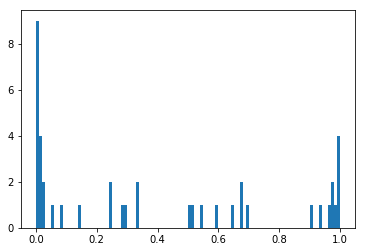

In [18]:
array_box = np.asarray(wrong_box)
plt.hist(array_box, bins=100, normed=False)